En este notebook modificaremos y emplearemos una red de tipo nnU-Net para obtener un detector multiclase para el control de la evolución de lesiones medulares en pacientes con Esclerosis Múltiple.
Trabajaremos con un conjunto de imágenes FLAIR propio, que dividiremos en entrenamiento y pruebas. En este conjunto las imágenes vienen agrupadas en grupos de tres:
* Imagen basal: contiene la imagen previa a la imagen de seguimiento del paciente.
* Imagen de seguimiento: es la imagen tomada en el seguimiento del paciente que debemos comparar con la imagen basal.
* Máscara multiclase de las lesiones: comprende el etiquetado final de la detección multiclase.

Las imágenes están en la carpeta lesiones de drive.

# 1. Descarga, análisis y pre-procesado de los datos 

## 1.1 Carga de librerias y de los datos

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline 
try:
    import nibabel as nib #for loading data from NIfTI images
except:
    raise ImportError('Install NIBABEL')
from tqdm import tqdm
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from random import *
from skimage.io import imread
from glob import glob
from collections import OrderedDict
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torch
import tensorflow as tf
from keras import backend as K

## 1.2 Exploración inicial

Mostraremos algunas imágenes para ver el estado de nuestro dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Establecemos nuestra ruta
root_dir = "/content/drive/MyDrive"

base_dir = '/content/drive/MyDrive/Colab Notebooks'
os.chdir(base_dir)

# Listamos las imágenes
glob(os.path.join(root_dir,'lesiones','*'))


Mounted at /content/drive


NameError: ignored

 Agrupamos las imágenes basales, las de seguimiento y las máscaras en tres connjuntos para facilitar la división en conjuntos de entrenamiento, test y validación


In [ ]:
# Dividimos las imágenes en máscaras, imágenes basales e imágenes de seguimiento
total_imagenes =sorted(glob(os.path.join(root_dir,'Lesiones','*')))
mascaras = list(filter(lambda x: x.find("mask") !=-1, total_imagenes)) 
img_basales = list(filter(lambda x:x.endswith("0000.nii.gz") , total_imagenes))
img_seguimiento = list(filter(lambda x:x.endswith("0001.nii.gz") , total_imagenes) )
# Mostramos el total de imágenes y las primeras imágenes de cada lista
print(len(total_imagenes),' matching files found:',img_basales[0], img_seguimiento[0], mascaras[0])

352  matching files found: /content/drive/MyDrive/Lesiones/FIS_001_01_0000.nii.gz /content/drive/MyDrive/Lesiones/FIS_001_01_0001.nii.gz /content/drive/MyDrive/Lesiones/FIS_001_mask_def.nii.gz


Text(0.5, 1.0, 'Máscara')

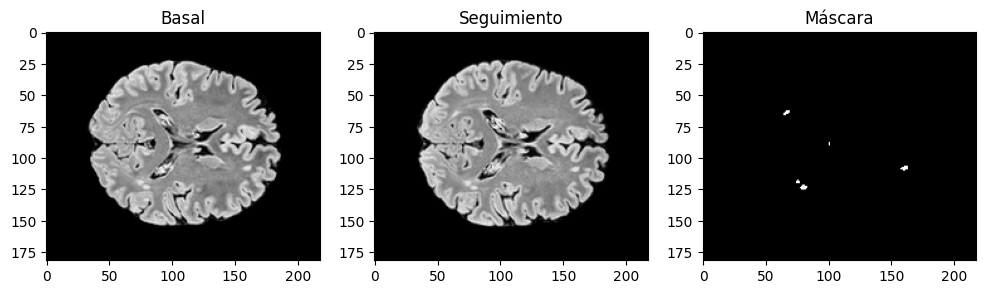

In [ ]:
# Mostramos unas imágenes al azar

x = randint(1, 117)
muestra_basal = nib.load(img_basales[x]).get_fdata()
muestra_seguimiento =nib.load(img_seguimiento[x]).get_fdata()
muestra_mascara = nib.load(mascaras[x]).get_fdata()
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(muestra_basal[:, :, muestra_basal.shape[2]//2],cmap='gray')
ax1.set_title('Basal')
ax2.imshow(muestra_seguimiento[:, :, muestra_seguimiento.shape[2]//2],cmap='gray')
ax2.set_title('Seguimiento')
ax3.imshow(muestra_mascara[:, :, muestra_seguimiento.shape[2]//2],cmap='gray')
ax3.set_title('Máscara')

# 2. Preparación y entrenamiento de nnU-Net

Aquí realizaremos los pasos necesarios para poder trabajar con el framework nnU-Net

## 2.1. Instalación de nnU-Net

Comenzamos instalando el framework.

In [ ]:
!git clone https://github.com/MIC-DKFZ/nnUNet.git

fatal: destination path 'nnUNet' already exists and is not an empty directory.


In [ ]:
nnunet_dir = '/content/drive/MyDrive/Colab Notebooks/nnUNet'
os.chdir(nnunet_dir)

In [ ]:
!pip install -e .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/nnUNet
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.8/151.8 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 91.3 MB/s 

Instalamos Hiddenlayer para que nos muestre la topología de red que está creando

In [ ]:
!pip install --upgrade git+https://github.com/julien-blanchon/hiddenlayer.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/julien-blanchon/hiddenlayer.git to /tmp/pip-req-build-qnn3vqz7
  Running command git clone --filter=blob:none --quiet https://github.com/julien-blanchon/hiddenlayer.git /tmp/pip-req-build-qnn3vqz7
  Resolved https://github.com/julien-blanchon/hiddenlayer.git to commit 8e14b20dbe9888630b07d70e2a55cf080b5bd5a9
  Preparing metadata (setup.py) ... done
  Created wheel for hiddenlayer: filename=hiddenlayer-0.2-py3-none-any.whl size=19783 sha256=b747dca7bc66d267c627fca084fb8ed45de7908d068a47866895a5be23267a6f
  Stored in directory: /tmp/pip-ephem-wheel-cache-txz3xjx3/wheels/a8/d7/ff/9a546c63a8b4ca9d619484b657dfbb44d4a70a450911423d9c
Successfully built hiddenlayer



## 2.2 Preparación del dataset dividiéndolo en imágenes y etiquetas para nnU-Net

Crearemos una estructura de carpetas adecuada a las necesidades de nnU-Net

In [ ]:
# Creamos la función para crear directorios si no existen
def make_if_dont_exist(folder_path,overwrite=False):    
    if os.path.exists(folder_path):
        # Si existe lo indicamos
        if not overwrite:
            print(f"{folder_path} exists.")
        else:
            print(f"{folder_path} overwritten")
            shutil.rmtree(folder_path)
            os.makedirs(folder_path)

    else:
      # No existe creamos el directorio
      os.makedirs(folder_path)
      print(f"{folder_path} created!")
# Creamos la estructura de carpetas y distribuimos las imágenes
task_name = 'Dataset101_SLEM'
nnunet_dir = "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data"
task_folder_name = os.path.join(nnunet_dir,task_name)
img_dir = '/content/drive/MyDrive/Lesiones'
# Creamos los directorios
make_if_dont_exist(task_folder_name+"/imagesTr",overwrite=False)
make_if_dont_exist(task_folder_name+"/imagesTs",overwrite=False)
make_if_dont_exist(task_folder_name+"/labelsTr",overwrite=False)
make_if_dont_exist(task_folder_name+"/labelsTs",overwrite=False)

train_image_dir = os.path.join(task_folder_name,'imagesTr')
train_label_dir = os.path.join(task_folder_name,'labelsTr')

test_image_dir = os.path.join(task_folder_name,'imagesTs')
test_label_dir = os.path.join(task_folder_name,'labelsTs')


/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/imagesTr exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/imagesTs exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTr exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs exists.


Tenemos 117 grupos de 3 imágenes cada uno (una imagen basal, una imagen actual y la etiqueta con la segmentación). Debemos dividir estas imágenes en conjuntos de entrenamiento y test. Aunque nnU-Net hace su propia división para entrenar los modelos, es interesante tener un conjunto para probar el rendimiento y comparar predicciones. Haremos una división 80%-20% para train y test.

In [ ]:
def copia_imagenes(origen, img_dir, image_dir, label_dir):
   ruta, file = os.path.split(origen)
   if file.endswith('.nii.gz'):
        # En ambos casos vamos a renombrar, tomamos el nombre original
        original_name = os.path.join(img_dir, file)

        # Separamos la base y la extensión
        base, extension = os.path.splitext(file)
        
        if file.find('mask')!=-1:
            # Tenemos una máscara, la renombramos para que el framework la reconozca
            # quitando '_mask_def'
            nueva_base = base.replace('_mask_def','')
            nueva_ruta = os.path.join(label_dir,nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)
        else:
            # Aquí también nos toca renombrar, vamos a quitar el _01_ 
            # central común a todas las imágenes
            nueva_base = base.replace('_01_','_')
            nueva_ruta = os.path.join(image_dir,nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)

# Vamos a hacer la división de forma manual
cantidad_tr = 94
cantidad_ts = 23
i = 0
while i < 117:
  x = randint(0, 10)
  if ( x > 5 and cantidad_ts > 0):
    image_dir = test_image_dir
    label_dir = test_label_dir
    cantidad_ts = cantidad_ts-1
  else:
    image_dir = train_image_dir
    label_dir = train_label_dir
  
  # Tomamos el archivo
  img_basal = img_basales[i]
  img_seg = img_seguimiento[i]
  etiqueta = mascaras[i]

  copia_imagenes(img_basal, img_dir,image_dir,label_dir)
  copia_imagenes(img_seg, img_dir,image_dir,label_dir)
  copia_imagenes(etiqueta, img_dir,image_dir,label_dir)
  # Incrementamos i
  i = i+1

KeyboardInterrupt: ignored

Verificamos que se han copiado bien los datos

In [ ]:
train_files = os.listdir(train_image_dir)
label_files = os.listdir(train_label_dir)
print("train image files:",len(train_files))
print("train label files:",len(label_files))
print("Matches:",len(set(train_files).intersection(set(label_files))))

test_files = os.listdir(test_image_dir)
label_tfiles = os.listdir(test_label_dir)
print("test image files:",len(test_files))
print("test label files:",len(label_tfiles))

train image files: 188
train label files: 94
Matches: 0
test image files: 46
test label files: 23


## 2.3 Configuración de nnU-Net

Ahora vamos a configurar nnU-Net para que se adapte a nuestro dataset

In [ ]:
overwrite_json_file = True #make it True if you want to overwrite the dataset.json file in Task_folder
json_file_exist = False

if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
    print('dataset.json already exist!')
    json_file_exist = True

if json_file_exist==False or overwrite_json_file:

    json_dict = OrderedDict()
    json_dict['name'] = task_name
    json_dict['tensorImageSize'] = "4D"
    

    #you may mention more than one modality
    json_dict['channel_names'] = {
        "0": "FLAIR",
        "1": "t2"
    }
    #labels+1 should be mentioned for all the labels in the dataset
    json_dict['labels'] = {
        "background": 0,
        "Lesions_without_changes": 1,
        "New_or_changing_lesions": 2
    }
    
    train_ids = os.listdir(train_label_dir)
    test_ids = os.listdir(test_label_dir)
    json_dict['numTraining'] = len(train_ids)
    json_dict['numTest'] = len(test_ids)
    json_dict['training'] = [{'image': "./imagesTr/%s.nii.gz" % i, "label": "./labelsTr/%s.nii.gz" % i} for i in train_ids]
    json_dict['test'] = ["./imagesTs/%s.nii.gz" % i for i in test_ids]

    json_dict['file_ending'] = ".nii.gz"


    with open(os.path.join(task_folder_name,"dataset.json"), 'w') as f:
        json.dump(json_dict, f, indent=4, sort_keys=False)

    if os.path.exists(os.path.join(task_folder_name,'dataset.json')):
        if json_file_exist==False:
            print('dataset.json created!')
        else: 
            print('dataset.json overwritten!')

dataset.json already exist!
dataset.json overwritten!


Creamos las variables de entorno

In [ ]:
# Vamos a crear las variables de entorno
mount_dir = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2'
print("Current Working Directory {}".format(os.getcwd()))
path_dict = {
    "nnUNet_raw" : os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data"), 
    "nnUNet_preprocessed" : os.path.join(mount_dir, "nnUNet_preprocessed"),
    "nnUNet_results" : os.path.join(mount_dir, "nnUNet_Results_Folder"),
}

# Write paths to environment variables
for env_var, path in path_dict.items():
  os.environ[env_var] = path 

# Check whether all environment variables are set correct!
for env_var, path in path_dict.items():
  if os.getenv(env_var) != path:
    print("Error:")
    print("Environment Variable {} is not set correctly!".format(env_var))
    print("Should be {}".format(path))
    print("Variable is {}".format(os.getenv(env_var)))
  make_if_dont_exist(path, overwrite=False)

print("If No Error Occured Continue Forward. =)")

!export nnUNet_raw=os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data")
!export nnUNet_preprocessed=os.path.join(mount_dir, "nnUNet_preprocessed")
!export nnUNet_results=os.path.join(mount_dir, "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder")

Current Working Directory /content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_preprocessed exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder exists.
If No Error Occured Continue Forward. =)
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_raw=os.path.join(mount_dir, "nnUNet_raw_data_base/nnUNet_raw_data")'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_preprocessed=os.path.join(mount_dir, "nnUNet_preprocessed")'
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `export nnUNet_results=os.path.join(mount_dir, "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder")'


Verificamos que los dataset estén correctos

In [ ]:
#running it from the experiment_planning folder to verify the path settings
main_dir = os.path.join(base_dir,'nnUNet/nnunetv2')
os.chdir(main_dir)
#!nnUNetv2_plan_and_preprocess -d 101 --verify_dataset_integrity
os.chdir(main_dir)

## 2.4 Entrenamiento de nnU-Net

Antes de entrenar nnU-Net modificaremos el trainer para poder salvar en cada epoch un checkpoint y además limitar a 100 y 110 el número de epochs de entrenamiento. Pare ello crearemos una clase que copiaremos en nnUNet/nnunetv2/training/nnUNetTrainer/variants/training_length/nnUNetTrainer_Xepochs.py 

In [ ]:
# Creamos nuestra propia clase para que entrene con 100 epochs
# Y que además guarde un checkpoint en cada epoch
class nnUNetTrainer_100epochsCheck(nnUNetTrainer):
    def __init__(self, plans: dict, configuration: str, fold: int, dataset_json: dict, unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        self.num_epochs = 100
        self.save_every = 1
# Creamos nuestra propia clase para que entrene con 110 epochs
# Y que además guarde un checkpoint en cada epoch
class nnUNetTrainer_110epochsCheck(nnUNetTrainer):
    def __init__(self, plans: dict, configuration: str, fold: int, dataset_json: dict, unpack_dataset: bool = True,
                 device: torch.device = torch.device('cuda')):
        super().__init__(plans, configuration, fold, dataset_json, unpack_dataset, device)
        self.num_epochs = 110   
        self.save_every = 1 

NameError: ignored

Ahora entrenamos la nnU-Net con los datos ya validados y preprocesados

In [ ]:
!nnUNetv2_train 101 3d_fullres 0 -tr nnUNetTrainer_110epochsCheck --npz

Using device: cuda:0
/usr/local/lib/python3.10/dist-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

Traceback (most recent call last):
  File "/usr/local/bin/nnUNetv2_train", line 33, in <module>
    sys.exit(load_entry_point('nnunetv2', 'console_scripts', 'nnUNetv2_train')())
  File "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/run/run_training.py", line 253, in run_training_entry
    run_training(arg

## 2.5. Determinación del mejor modelo obtenido

Ahora toca evaluar el mejor modelo de los tres obtenidos por nnU-Net.

In [ ]:
!nnUNetv2_find_best_configuration 101 -f 0 -c 3d_fullres -tr nnUNetTrainer_110epochsCheck


***All results:***
nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres: 0.6024453261742156

*Best*: nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres: 0.6024453261742156

***Determining postprocessing for best model/ensemble***
Removing all but the largest foreground region did not improve results!
Removing all but the largest component for 1 did not improve results! Dice before: 0.71423 after: 0.35516
Removing all but the largest component for 2 did not improve results! Dice before: 0.49066 after: 0.43373

***Run inference like this:***

nnUNetv2_predict -d Dataset101_SLEM -i INPUT_FOLDER -o OUTPUT_FOLDER -f  0 -tr nnUNetTrainer_100epochsCheck -c 3d_fullres -p nnUNetPlans

***Once inference is completed, run postprocessing like this:***

nnUNetv2_apply_postprocessing -i OUTPUT_FOLDER -o OUTPUT_FOLDER_PP -pp_pkl_file /content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset101_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/crossval_results_

## 2.6. Predicciones con nuestro mejor modelo

Ahora haremos predicciones con nuestro mejor modelo, para ello emplearemos la carpeta /content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/imagesTs y sus máscaras situadas en /content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs

 Lo primero que haremos será crear una carpeta para las predicciones

In [ ]:
# Creamos la carpeta para las predicciones,
# así tenemos todas guardadas para hacer la matriz de confusión
ruta_predic = '/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset101_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/labelsPr'
make_if_dont_exist(ruta_predic, overwrite=False)

/content/drive/MyDrive/Colab Notebooks (1)/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset101_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/labelsPr exists.


In [ ]:
# Hacemos las predicciones
!nnUNetv2_predict -d Dataset101_SLEM -i "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/imagesTs" -o "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset101_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres/labelsPr" -f  0 -tr nnUNetTrainer_100epochsCheck -c 3d_fullres -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 23 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 23 cases that I would like to predict
using pin_memory on device 0

Predicting FIS_005:
perform_everything_on_gpu: True
Prediction done, transferring to CPU if needed
sending off prediction to background worker for resampling and export
done with FIS_005

Predicting FIS_007:
perform_everything_on_gpu: True
Prediction done, transferring to CPU if needed
sending off prediction to background worker for resampling and export
done with FIS_007

Predicting FIS_014:
perform_ev

In [ ]:
# Preparamos los dos conjuntos de datos para comparar
y_true = sorted(glob(os.path.join(task_folder_name,'labelsTs','*')))
rutaPred = "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset101_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres"
ficheros_p = sorted(glob(os.path.join(rutaPred,"labelsPr",'*')))
# Tomamos sólo las imágenes de las predicciones
y_pred = list(filter(lambda x:x.endswith(".nii.gz") , ficheros_p))
print("true mask files:",len(y_true))
print("predicted mask files:",len(y_pred))

true mask files: 23
predicted mask files: 23


## 2.7. Obtención del valor de DICE de nuestro modelo

In [ ]:
# Crearemos la función dice para evitar dividir por 0
def dice( y_true, y_pred):
    epsilon = 1e-2
    y_pred_arg = tf.math.argmax(y_pred, axis = -1)
    y_true_f = tf.cast(K.flatten(y_true), tf.int64)
    y_pred_f = tf.cast(K.flatten(y_pred), tf.int64)
    intersection = tf.cast(K.sum(y_true_f * y_pred_f), tf.float32)
    dice = (2 * intersection + epsilon) / (tf.cast(K.sum(y_true_f), tf.float32) + tf.cast(K.sum(y_pred_f), tf.float32) + epsilon)
    return tf.cast(dice, tf.float32)


In [ ]:
valoresDICE = []

for i in range(23):  
   predict = nib.load(y_pred[i])
   prediction = np.asanyarray(predict.dataobj) 
   label = nib.load(y_true[i])
   mascara = np.asanyarray(label.dataobj)
   DICE = dice(mascara, prediction)
   valoresDICE.append(DICE)

In [ ]:
# Ya tenemos la lista de valores, ahora obtenemos el promedio
media_DICE = np.mean(valoresDICE)
std_DICE = np.std(valoresDICE)

# Mostramos datos
print("Valor medio de DICE:",media_DICE)
print("Desviación típica de DICE:",std_DICE)

NameError: ignored

## 2.8. Obtención de la matriz de confusión de nuestro modelo

In [ ]:
# Necesitaremos hacer nuestra función que genere la matriz de confusión a mano
def confusion_matrix(preds, labels, conf_m, sample_size):
    preds = preds.flatten()
    labels = labels.flatten()
    for i in range(len(preds)):
        #Comenzamos a rellenar 
        conf_m[int(preds[i]),int(labels[i])] += 1/(len(preds)*sample_size) 
    return conf_m

conf_m = torch.zeros(3,3) # tenemos 3 clases
# Recorreremos las imágenes para ir sumando la matriz de confusion
for i in range(23):    
    prediction = nib.load(y_pred[i]).get_fdata()
    label = nib.load(y_true[i]).get_fdata()
    conf_m = confusion_matrix(prediction, label,conf_m, 23)

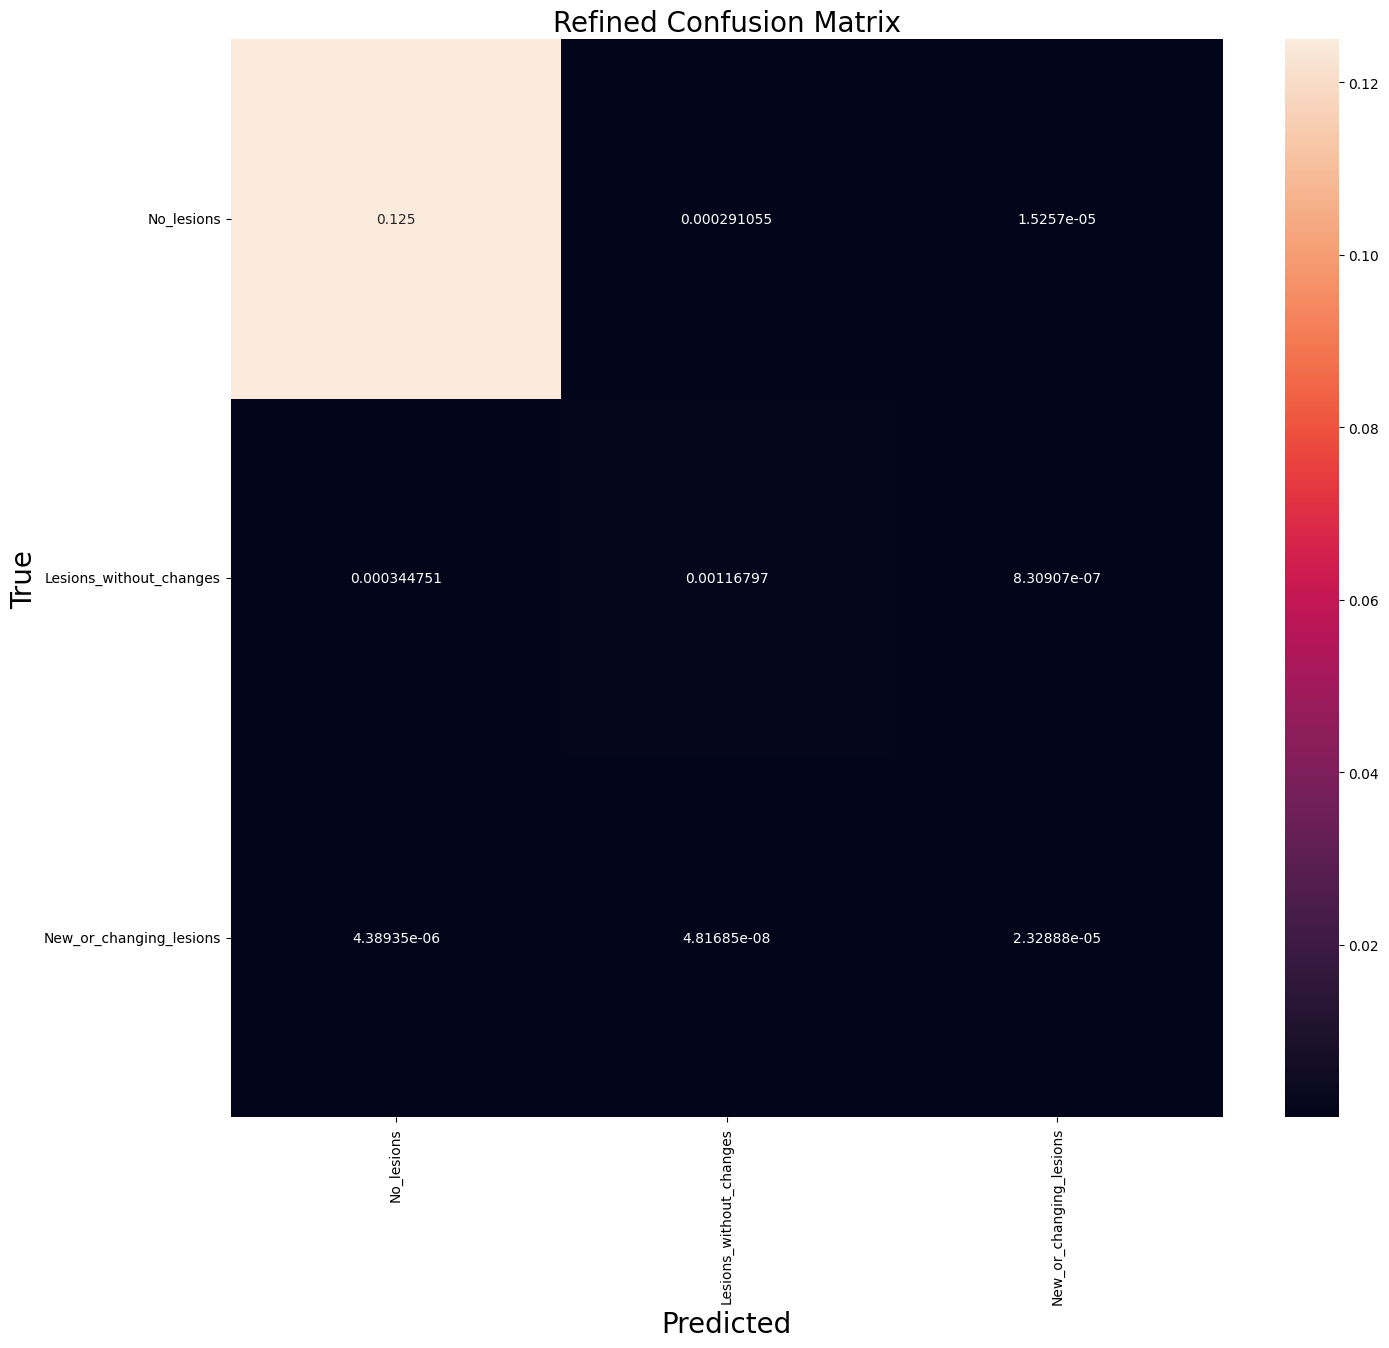

In [ ]:
#cm = confusion_matrix(y_true, y_pred)
## Indicamos las etiquetas
class_names = ['No_lesions','Lesions_without_changes','New_or_changing_lesions']
# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(conf_m, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# Damos formato a todo
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.show()

Ya tenemos la matriz de confusión, ahora vamos a comparar imágenes de forma visual

tf.Tensor(0.83712584, shape=(), dtype=float32)


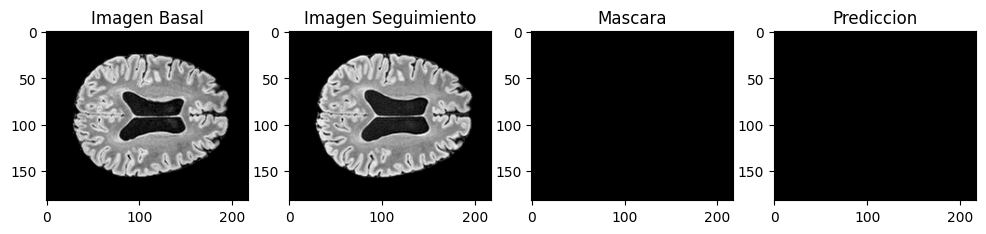

In [ ]:
# Mostramos la  primera imagen
y_test = sorted(glob(os.path.join(task_folder_name,'imagesTs','*')))
img_basales_t = list(filter(lambda x: x.find("0000") !=-1 , y_test))
img_seguimiento_t = list(filter(lambda x: x.find("0001") !=-1 , y_test) )

img_basal = nib.load(img_basales_t[0]).get_fdata()
img_seg = nib.load(img_seguimiento_t[0]).get_fdata()
mascara = nib.load(y_true[0]).get_fdata()
prediccion =nib.load(y_pred[0]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[0])

tf.Tensor(0.73630196, shape=(), dtype=float32)


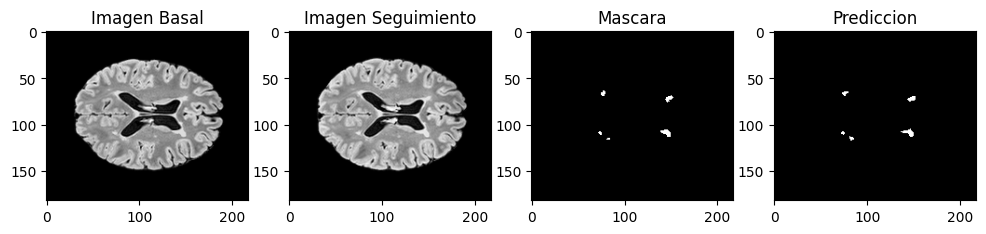

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[1]).get_fdata()
img_seg = nib.load(img_seguimiento_t[1]).get_fdata()
mascara = nib.load(y_true[1]).get_fdata()
prediccion =nib.load(y_pred[1]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[1])

tf.Tensor(0.78884673, shape=(), dtype=float32)


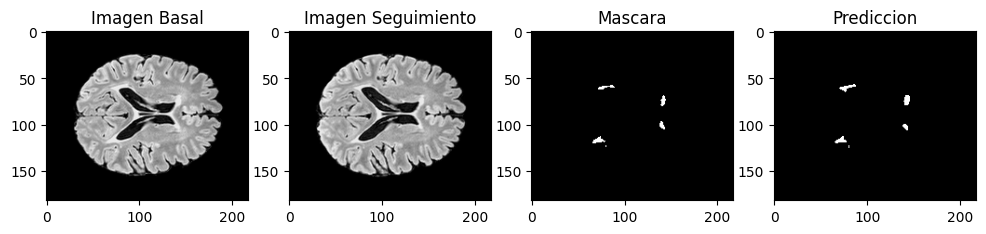

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[2]).get_fdata()
img_seg = nib.load(img_seguimiento_t[2]).get_fdata()
mascara = nib.load(y_true[2]).get_fdata()
prediccion =nib.load(y_pred[2]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[2])

tf.Tensor(0.8786385, shape=(), dtype=float32)


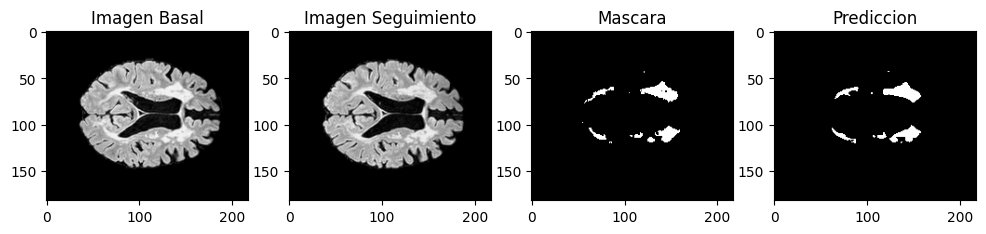

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[3]).get_fdata()
img_seg = nib.load(img_seguimiento_t[3]).get_fdata()
mascara = nib.load(y_true[3]).get_fdata()
prediccion =nib.load(y_pred[3]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[3])

tf.Tensor(0.77894753, shape=(), dtype=float32)


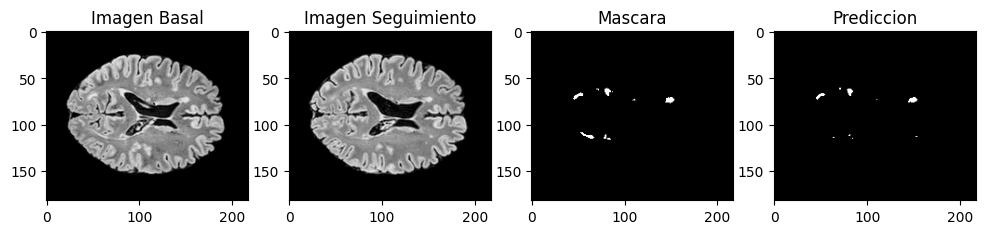

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[4]).get_fdata()
img_seg = nib.load(img_seguimiento_t[4]).get_fdata()
mascara = nib.load(y_true[4]).get_fdata()
prediccion =nib.load(y_pred[4]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[4])

tf.Tensor(0.7937976, shape=(), dtype=float32)


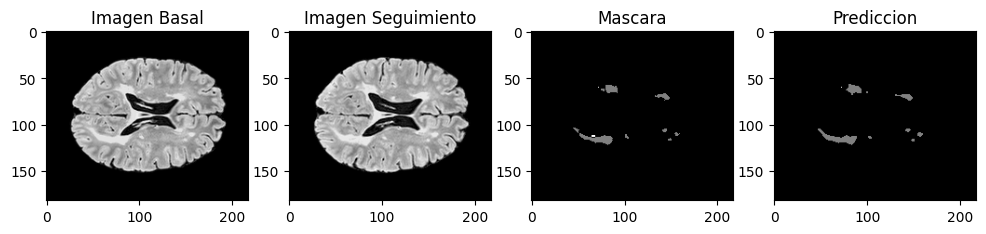

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[5]).get_fdata()
img_seg = nib.load(img_seguimiento_t[5]).get_fdata()
mascara = nib.load(y_true[5]).get_fdata()
prediccion =nib.load(y_pred[5]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[5])

tf.Tensor(0.75937796, shape=(), dtype=float32)


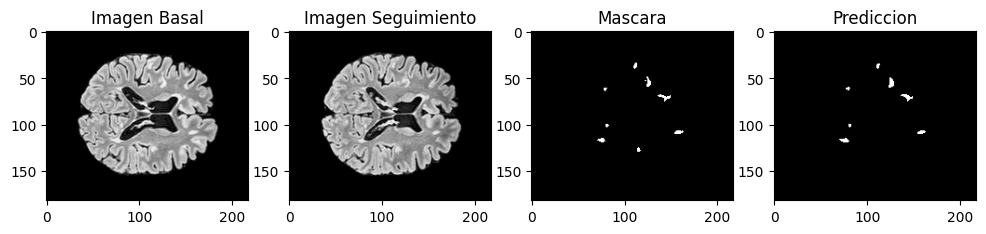

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[6]).get_fdata()
img_seg = nib.load(img_seguimiento_t[6]).get_fdata()
mascara = nib.load(y_true[6]).get_fdata()
prediccion =nib.load(y_pred[6]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[6])

tf.Tensor(0.7224009, shape=(), dtype=float32)


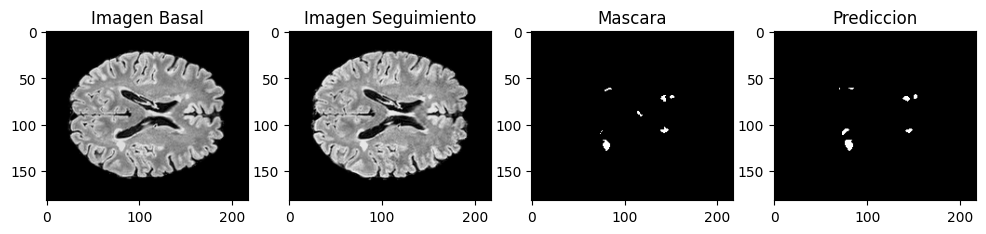

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[7]).get_fdata()
img_seg = nib.load(img_seguimiento_t[7]).get_fdata()
mascara = nib.load(y_true[7]).get_fdata()
prediccion =nib.load(y_pred[7]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[7])

tf.Tensor(1.036817, shape=(), dtype=float32)


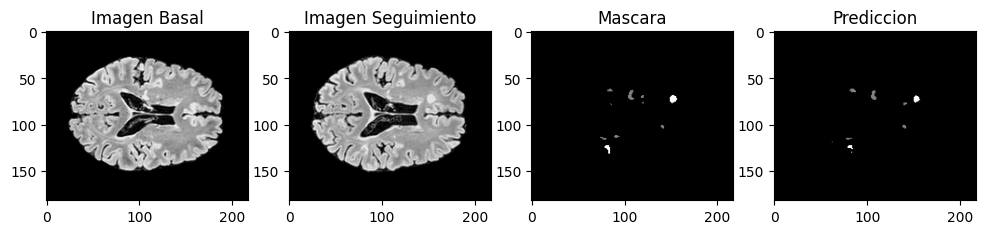

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[8]).get_fdata()
img_seg = nib.load(img_seguimiento_t[8]).get_fdata()
mascara = nib.load(y_true[8]).get_fdata()
prediccion =nib.load(y_pred[8]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[8])

tf.Tensor(0.70786643, shape=(), dtype=float32)


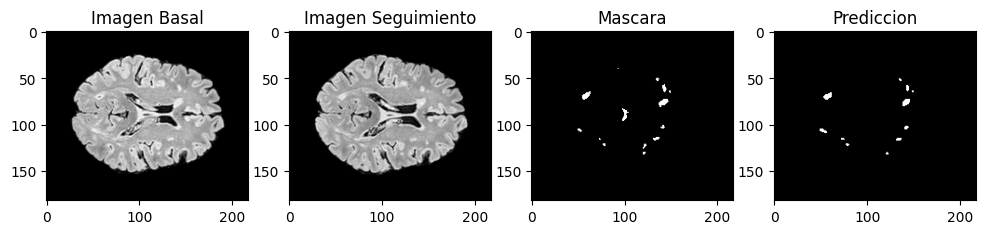

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[9]).get_fdata()
img_seg = nib.load(img_seguimiento_t[9]).get_fdata()
mascara = nib.load(y_true[9]).get_fdata()
prediccion =nib.load(y_pred[9]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[9])

tf.Tensor(0.83895606, shape=(), dtype=float32)


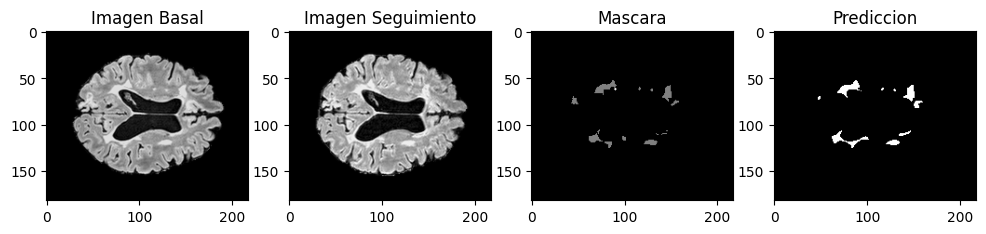

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[10]).get_fdata()
img_seg = nib.load(img_seguimiento_t[10]).get_fdata()
mascara = nib.load(y_true[10]).get_fdata()
prediccion =nib.load(y_pred[10]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[10])

tf.Tensor(0.8245327, shape=(), dtype=float32)


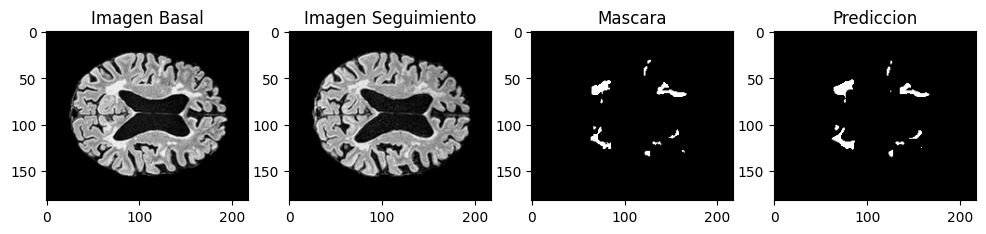

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[11]).get_fdata()
img_seg = nib.load(img_seguimiento_t[11]).get_fdata()
mascara = nib.load(y_true[11]).get_fdata()
prediccion =nib.load(y_pred[11]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[11])

tf.Tensor(0.8437645, shape=(), dtype=float32)


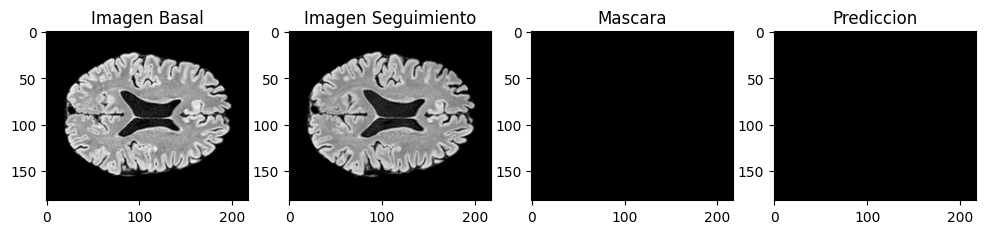

In [ ]:
img_basal = nib.load(img_basales_t[12]).get_fdata()
img_seg = nib.load(img_seguimiento_t[12]).get_fdata()
mascara = nib.load(y_true[12]).get_fdata()
prediccion =nib.load(y_pred[12]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[12])

tf.Tensor(0.7564938, shape=(), dtype=float32)


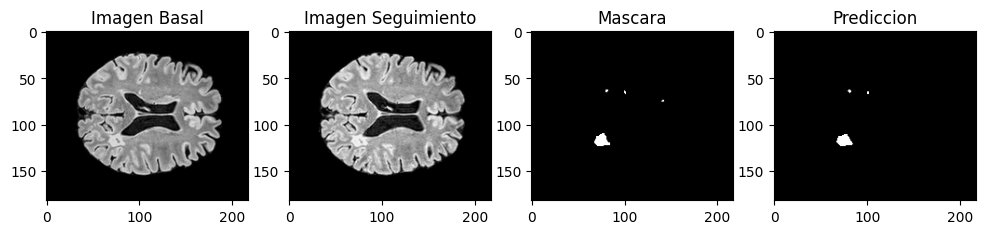

In [ ]:
img_basal = nib.load(img_basales_t[13]).get_fdata()
img_seg = nib.load(img_seguimiento_t[13]).get_fdata()
mascara = nib.load(y_true[13]).get_fdata()
prediccion =nib.load(y_pred[13]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[13])

tf.Tensor(0.7067772, shape=(), dtype=float32)


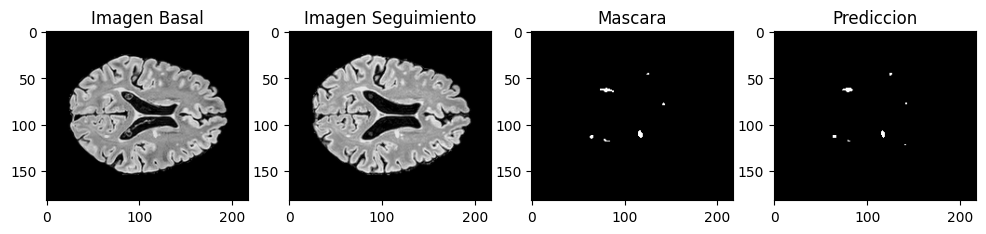

In [ ]:
img_basal = nib.load(img_basales_t[14]).get_fdata()
img_seg = nib.load(img_seguimiento_t[14]).get_fdata()
mascara = nib.load(y_true[14]).get_fdata()
prediccion =nib.load(y_pred[14]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[14])

tf.Tensor(0.71605676, shape=(), dtype=float32)


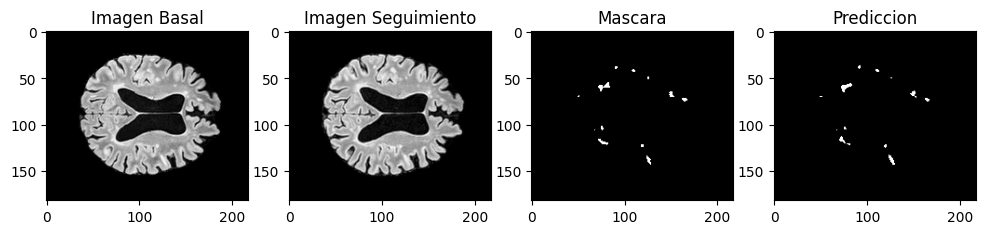

In [ ]:
img_basal = nib.load(img_basales_t[15]).get_fdata()
img_seg = nib.load(img_seguimiento_t[15]).get_fdata()
mascara = nib.load(y_true[15]).get_fdata()
prediccion =nib.load(y_pred[15]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[15])

tf.Tensor(0.68487364, shape=(), dtype=float32)


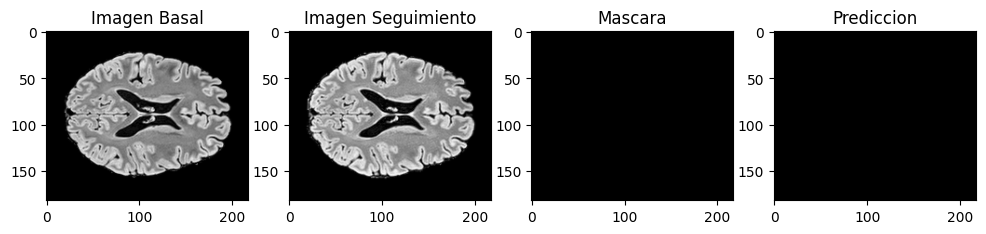

In [ ]:
img_basal = nib.load(img_basales_t[16]).get_fdata()
img_seg = nib.load(img_seguimiento_t[16]).get_fdata()
mascara = nib.load(y_true[16]).get_fdata()
prediccion =nib.load(y_pred[16]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[16])

tf.Tensor(0.72739726, shape=(), dtype=float32)


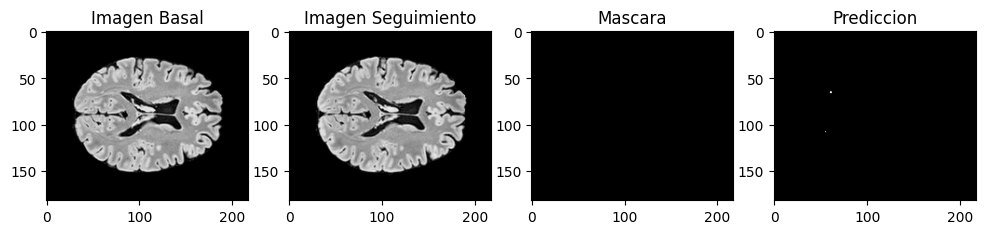

In [ ]:
img_basal = nib.load(img_basales_t[17]).get_fdata()
img_seg = nib.load(img_seguimiento_t[17]).get_fdata()
mascara = nib.load(y_true[17]).get_fdata()
prediccion =nib.load(y_pred[17]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[17])

tf.Tensor(0.7594109, shape=(), dtype=float32)


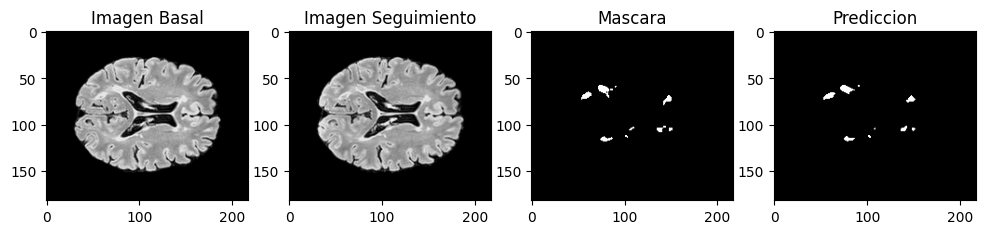

In [ ]:
img_basal = nib.load(img_basales_t[18]).get_fdata()
img_seg = nib.load(img_seguimiento_t[18]).get_fdata()
mascara = nib.load(y_true[18]).get_fdata()
prediccion =nib.load(y_pred[18]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[18])

tf.Tensor(0.7732861, shape=(), dtype=float32)


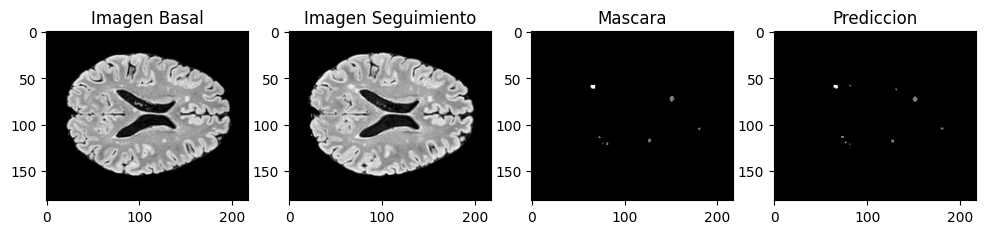

In [ ]:
# Mostramos la  primera imagen
img_basal = nib.load(img_basales_t[19]).get_fdata()
img_seg = nib.load(img_seguimiento_t[19]).get_fdata()
mascara = nib.load(y_true[19]).get_fdata()
prediccion =nib.load(y_pred[19]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[19])

tf.Tensor(0.7390621, shape=(), dtype=float32)


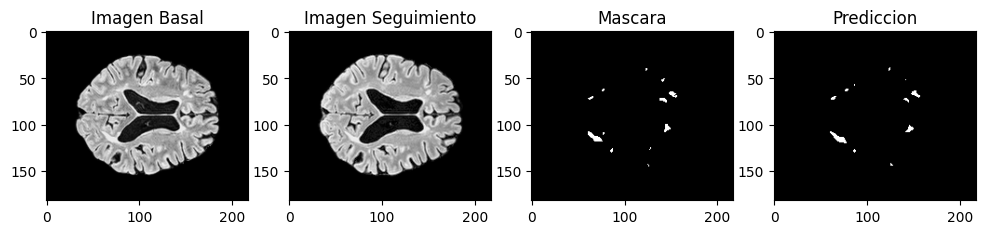

In [ ]:
img_basal = nib.load(img_basales_t[20]).get_fdata()
img_seg = nib.load(img_seguimiento_t[20]).get_fdata()
mascara = nib.load(y_true[20]).get_fdata()
prediccion =nib.load(y_pred[20]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[20])

tf.Tensor(0.87153643, shape=(), dtype=float32)


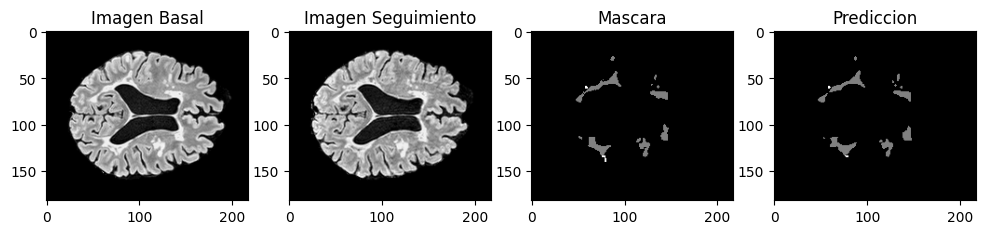

In [ ]:
img_basal = nib.load(img_basales_t[21]).get_fdata()
img_seg = nib.load(img_seguimiento_t[21]).get_fdata()
mascara = nib.load(y_true[21]).get_fdata()
prediccion =nib.load(y_pred[21]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[21])

tf.Tensor(0.7649968, shape=(), dtype=float32)


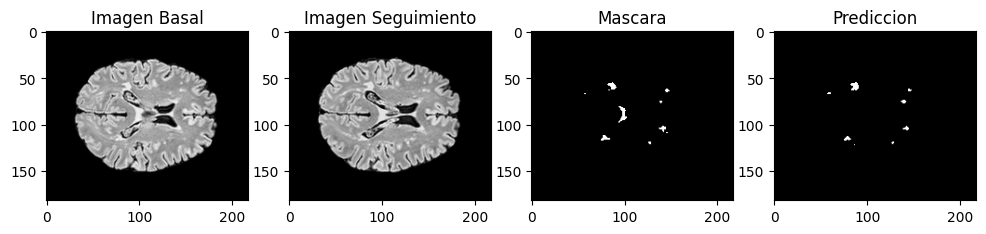

In [ ]:
img_basal = nib.load(img_basales_t[22]).get_fdata()
img_seg = nib.load(img_seguimiento_t[22]).get_fdata()
mascara = nib.load(y_true[22]).get_fdata()
prediccion =nib.load(y_pred[22]).get_fdata()
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
ax1.imshow(img_basal[:, :, img_basal.shape[2]//2],cmap='gray')
ax1.set_title('Imagen Basal')
ax2.imshow(img_seg[:, :, img_seg.shape[2]//2],cmap='gray')
ax2.set_title('Imagen Seguimiento')
ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
ax3.set_title('Mascara')
ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
ax4.set_title('Prediccion')
print(valoresDICE[22])

## 2.9. Predicciones con lesiones ajenas al conjunto de entrenamiento

Se realiza una predicción con lesiones ajenas.

Comenzamos con un ejemplo de imagen ajena


In [ ]:
!nnUNetv2_predict -d Dataset101_SLEM -i "/content/drive/MyDrive/Colab Notebooks/nnUNet/Test" -o "/content/drive/MyDrive/Colab Notebooks/nnUNet/Resultados_test" -f  0 -tr nnUNetTrainer_100epochsCheck -c 3d_fullres -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 1 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 1 cases that I would like to predict
using pin_memory on device 0

Predicting 095:
perform_everything_on_gpu: True
Prediction done, transferring to CPU if needed
sending off prediction to background worker for resampling and export
done with 095


Veamos si lo ha hecho bien observando las imágenes

Text(0.5, 1.0, 'Máscara')

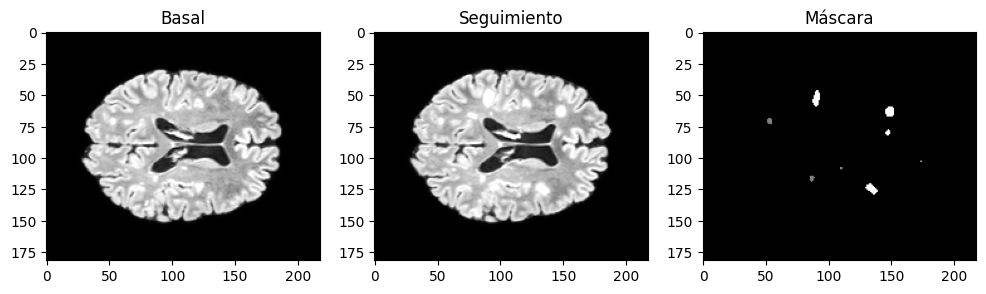

In [ ]:
# Mostramos los resultados
dir_raiz = '//content/drive/MyDrive/Colab Notebooks/nnUNet/'
total_imagenes =sorted(glob(os.path.join(dir_raiz,'Test','*')))
total_mask =sorted(glob(os.path.join(dir_raiz,'Resultados_test','*')))
mascaras = list(filter(lambda x: x.find(".nii.gz") !=-1, total_mask)) 
img_basales = list(filter(lambda x: x.find("0000") !=-1 , total_imagenes))
img_seguimiento = list(filter(lambda x: x.find("0001") !=-1 , total_imagenes) )
muestra_RMI = nib.load(img_basales[0]).get_fdata()
muestra_seg = nib.load(img_seguimiento[0]).get_fdata()
muestra_mascara = nib.load(mascaras[0]).get_fdata()
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize = (12, 6))
ax1.imshow(muestra_RMI[:, :, muestra_RMI.shape[2]//2],cmap='gray')
ax1.set_title('Basal')
ax2.imshow(muestra_seg[:, :, muestra_seg.shape[2]//2],cmap='gray')
ax2.set_title('Seguimiento')
ax3.imshow(muestra_mascara[:, :, muestra_mascara.shape[2]//2],cmap='gray')
ax3.set_title('Máscara')

### 2.9.1 Predicciones con datos del MSSEG-2

Ahora vamos a hacer predicciones con los datos del MSSEG-2. Para ello primero transformaremos las imágenes para que nnU-Net pueda trabajar con ellas y después debemos transformar las máscaras obtenidas para mostrar sólo las lesiones de tipo 2 como tipo 1.

In [ ]:
root_dir = "/content/drive/MyDrive"
# Dividimos las imágenes en máscaras e imágenes de entrenamiento. Tomaremos la imagen más reciente del paciente como baseline.
total_imagenes_MSSEG =sorted(glob(os.path.join(root_dir,'MSSEG','*.nii.gz')))
mascaras_MSSEG = list(filter(lambda x: x.find("mask") !=-1, total_imagenes_MSSEG)) 
img_basales_MSSEG = list(filter(lambda x: x.find("time01") !=-1 , total_imagenes_MSSEG))
img_seguimiento_MSSEG = list(filter(lambda x: x.find("time02") !=-1 , total_imagenes_MSSEG) )
# Mostramos el total de imágenes y las primeras imágenes de cada lista
print("Total_imagenes:",len(total_imagenes_MSSEG))
print("img_basales:",len(img_basales_MSSEG))
print("img_seguimiento:",len(img_seguimiento_MSSEG))
print("mascaras:",len(mascaras_MSSEG))

Total_imagenes: 120
img_basales: 40
img_seguimiento: 40
mascaras: 40


In [ ]:
# Código para transformar las imágenes a un formato que le guste a nnU-Net
def copia_imagenes_test(origen, img_dir, image_dir, label_dir):
   ruta, file = os.path.split(origen)
   if file.endswith('.nii.gz'):
        # En ambos casos vamos a renombrar, tomamos el nombre original
        original_name = os.path.join(img_dir, file)

        # Separamos la base y la extensión
        base, extension = os.path.splitext(file)
        
        if file.find('mask')!=-1:
            nueva_ruta = os.path.join(label_dir,base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)
        elif file.find('time01')!=-1:
            nueva_base = base.replace('time01_FL','0000')
            nueva_ruta = os.path.join(image_dir,nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)
        elif file.find('time02')!=-1:
            nueva_base = base.replace('time02_FL','0001')
            nueva_ruta = os.path.join(image_dir,nueva_base + extension)
            shutil.copy(os.path.join(img_dir,file),nueva_ruta)

In [ ]:
# Creamos los directorios
make_if_dont_exist(task_folder_name+"/imagesTs_MSSEG",overwrite=False)
make_if_dont_exist(task_folder_name+"/labelsTs_MSSEG",overwrite=False)

test_image_dir = os.path.join(task_folder_name,'imagesTs_MSSEG')
test_label_dir = os.path.join(task_folder_name,'labelsTs_MSSEG')

img_dir_MSSEG = '/content/drive/MyDrive/MSSEG'

i = 0
while i < 40:
  image_dir = test_image_dir
  label_dir = test_label_dir   
  
  # Tomamos el archivo
  img_basal = img_basales_MSSEG[i]
  img_seg = img_seguimiento_MSSEG[i]
  etiqueta = mascaras_MSSEG[i]

  copia_imagenes_test(img_basal, img_dir_MSSEG,image_dir,label_dir)
  copia_imagenes_test(img_seg, img_dir_MSSEG,image_dir,label_dir)
  copia_imagenes_test(etiqueta, img_dir_MSSEG,image_dir,label_dir)
  # Incrementamos i
  i = i+1


  

/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/imagesTs_MSSEG exists.
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG exists.


Ya tenemos las imágenes, ahora a predecir

In [ ]:
!nnUNetv2_predict -d Dataset101_SLEM -i "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/imagesTs_MSSEG" -o "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_MSSEG" -f  0 -tr nnUNetTrainer_100epochsCheck -c 3d_fullres -p nnUNetPlans


#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 40 cases in the source folder
I am process 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 40 cases that I would like to predict
using pin_memory on device 0

Predicting 013:
perform_everything_on_gpu: True
Prediction done, transferring to CPU if needed
sending off prediction to background worker for resampling and export
done with 013

Predicting 015:
perform_everything_on_gpu: True
Prediction done, transferring to CPU if needed
sending off prediction to background worker for resampling and export
done with 015

Predicting 016:
perform_everything_on_gpu: Tru

Como hemos hecho una detección multiclase, debemos transformar las máscaras generadas para cambiar el valor 1 por 0 y el valor 2 por 1

In [ ]:
archivos =sorted(glob(os.path.join(task_folder_name,'Predicciones_MSSEG','*')))
path = os.path.join(task_folder_name,"Predicciones_transformadas")
imagenes_transformar = list(filter(lambda x:x.endswith(".nii.gz") , archivos))

for i in range(len(imagenes_transformar)):
  mascara_p = imagenes_transformar[i]
  img_original = nib.load(mascara_p)
  matriz_original = img_original.get_fdata()
  matriz_original[matriz_original == 1] = 0
  matriz_original[matriz_original == 2] = 1

  # Guardamos la matriz resultado
  new_img = nib.Nifti1Image(matriz_original, affine=img_original.affine, header=img_original.header)
  # Daremos nombre al resultado
  ruta, file = os.path.split(mascara_p)
  # Separamos la base y la extensión
  base, extension = os.path.splitext(file)
  nueva_base = base.replace('.nii','_mask.nii')
  nueva_ruta = os.path.join(path, nueva_base + extension)
  nib.save(new_img, nueva_ruta)  

  

Obtenemos el valor DICE

In [ ]:
# Preparamos los dos conjuntos de datos para comparar
y_true = sorted(glob(os.path.join(task_folder_name,'labelsTs_MSSEG','*')))
#rutaPred = "/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_Results_Folder/Dataset101_SLEM/nnUNetTrainer_100epochsCheck__nnUNetPlans__3d_fullres"
ficheros_p = sorted(glob(os.path.join(task_folder_name,"Predicciones_transformadas",'*')))
# Tomamos sólo las imágenes de las predicciones
y_pred = list(filter(lambda x:x.endswith(".nii.gz") , ficheros_p))
print("true mask files:",len(y_true))
print("predicted mask files:",len(y_pred))

true mask files: 40
predicted mask files: 40


In [ ]:
valoresDICE = []

for i in range(40):  
   predict = nib.load(y_pred[i])
   prediction = np.asanyarray(predict.dataobj) 
   label = nib.load(y_true[i])
   mascara = np.asanyarray(label.dataobj)
   DICE = dice(mascara, prediction)
   valoresDICE.append(DICE)

In [ ]:
# Ya tenemos la lista de valores, ahora obtenemos el promedio
media_DICE = np.mean(valoresDICE)
std_DICE = np.std(valoresDICE)

# Mostramos datos
print("Valor medio de DICE:",media_DICE)
print("Desviación típica de DICE:",std_DICE)
valoresDICE

Valor medio de DICE: 0.51143426
Desviación típica de DICE: 0.3339291


[<tf.Tensor: shape=(), dtype=float32, numpy=0.36373276>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6504911>,
 <tf.Tensor: shape=(), dtype=float32, numpy=4.5452478e-05>,
 <tf.Tensor: shape=(), dtype=float32, numpy=1.0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65576595>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6396091>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6962509>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.47273096>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.6548267>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.24475761>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.8046051>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.00020404>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.65845025>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.28622413>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.38937384>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.25002405>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0

Muestra visual de los resultados

/content/drive/MyDrive/MSSEG/013_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/013_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/013_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/013_mask.nii.gz
tf.Tensor(0.36373276, shape=(), dtype=float32)


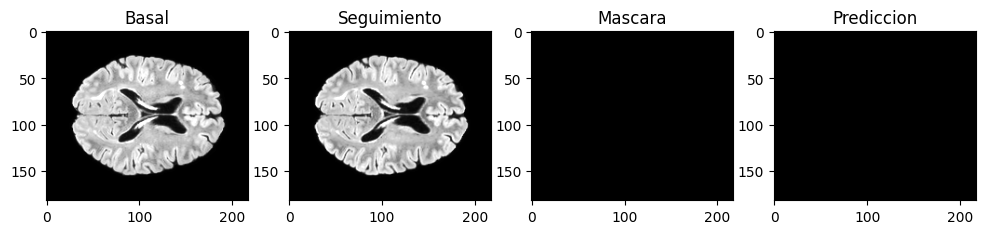

/content/drive/MyDrive/MSSEG/015_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/015_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/015_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/015_mask.nii.gz
tf.Tensor(1.0, shape=(), dtype=float32)


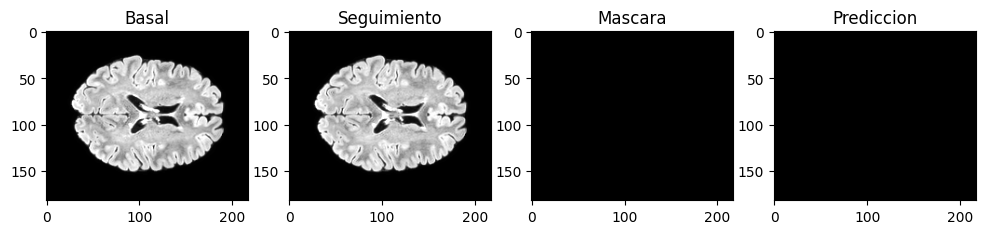

/content/drive/MyDrive/MSSEG/016_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/016_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/016_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/016_mask.nii.gz
tf.Tensor(0.6504911, shape=(), dtype=float32)


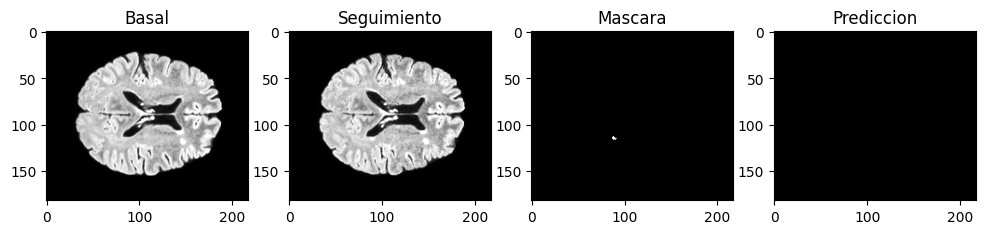

/content/drive/MyDrive/MSSEG/018_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/018_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/018_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/018_mask.nii.gz
tf.Tensor(4.5452478e-05, shape=(), dtype=float32)


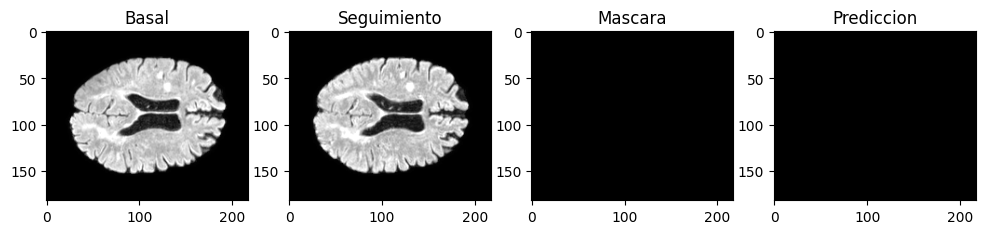

/content/drive/MyDrive/MSSEG/019_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/019_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/019_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/019_mask.nii.gz
tf.Tensor(1.0, shape=(), dtype=float32)


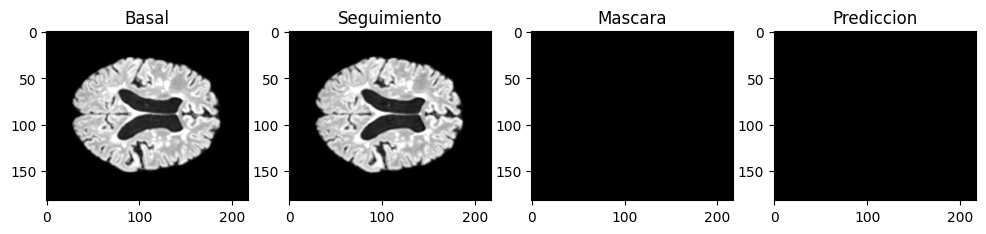

/content/drive/MyDrive/MSSEG/020_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/020_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/020_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/020_mask.nii.gz
tf.Tensor(0.65576595, shape=(), dtype=float32)


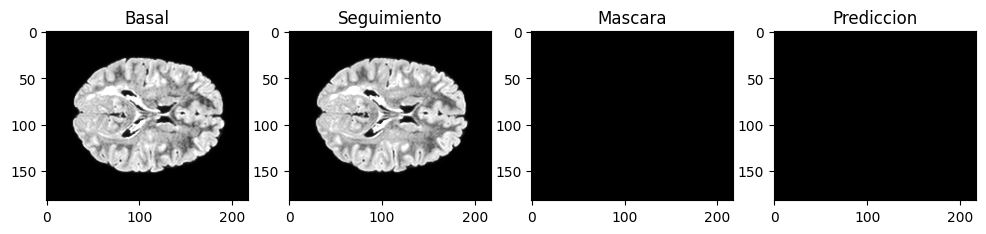

/content/drive/MyDrive/MSSEG/021_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/021_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/021_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/021_mask.nii.gz
tf.Tensor(0.6396091, shape=(), dtype=float32)


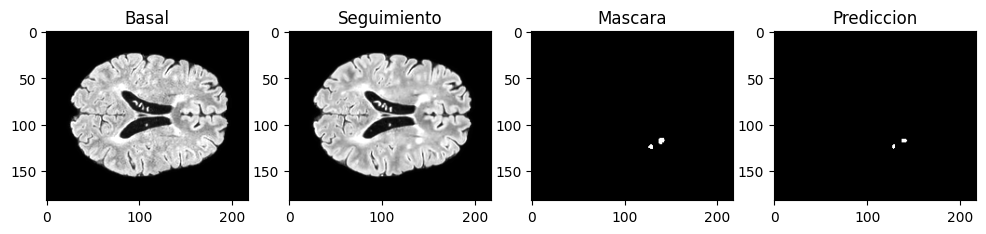

/content/drive/MyDrive/MSSEG/024_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/024_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/024_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/024_mask.nii.gz
tf.Tensor(0.6962509, shape=(), dtype=float32)


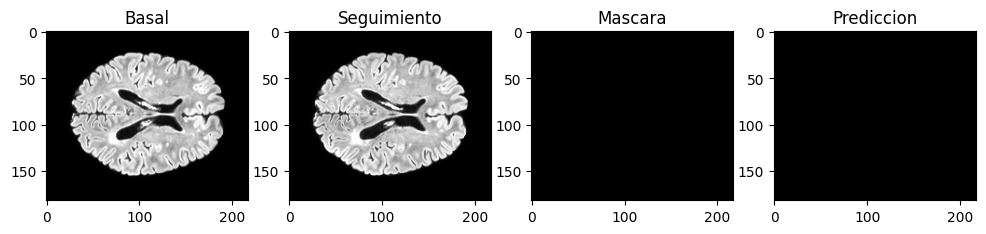

/content/drive/MyDrive/MSSEG/026_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/026_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/026_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/026_mask.nii.gz
tf.Tensor(0.47273096, shape=(), dtype=float32)


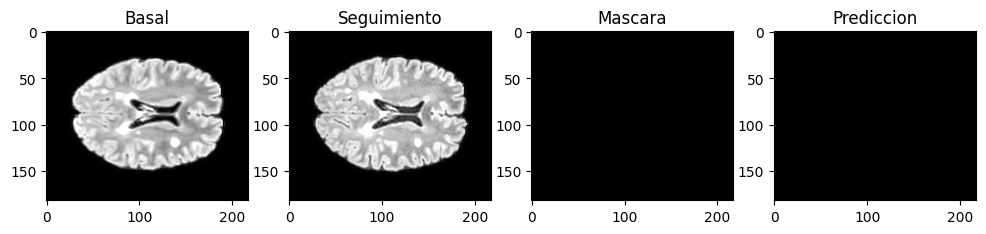

/content/drive/MyDrive/MSSEG/027_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/027_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/027_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/027_mask.nii.gz
tf.Tensor(0.6548267, shape=(), dtype=float32)


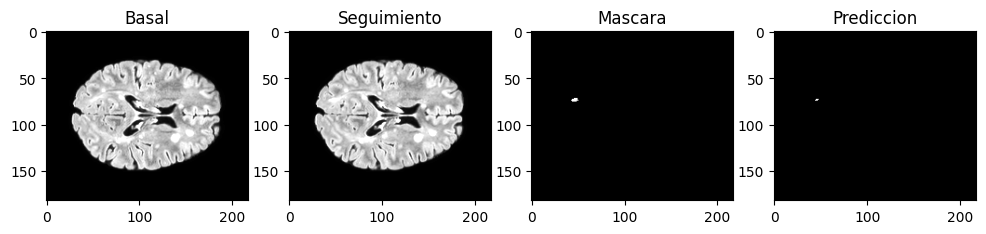

/content/drive/MyDrive/MSSEG/029_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/029_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/029_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/029_mask.nii.gz
tf.Tensor(0.24475761, shape=(), dtype=float32)


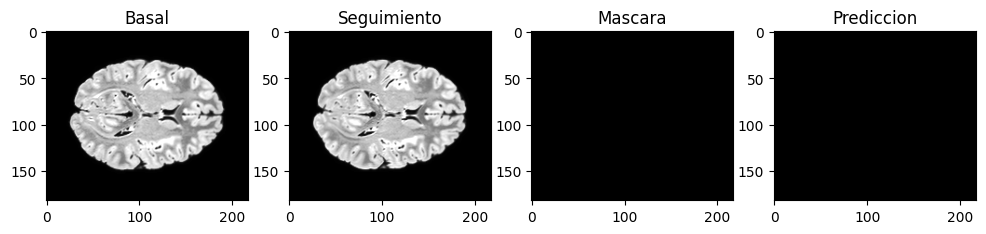

/content/drive/MyDrive/MSSEG/030_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/030_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/030_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/030_mask.nii.gz
tf.Tensor(0.8046051, shape=(), dtype=float32)


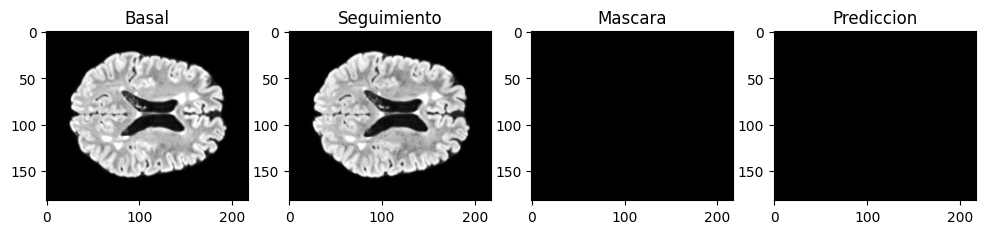

/content/drive/MyDrive/MSSEG/032_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/032_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/032_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/032_mask.nii.gz
tf.Tensor(0.00020404, shape=(), dtype=float32)


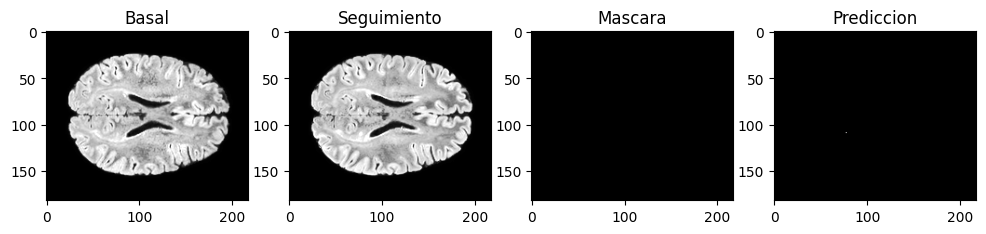

/content/drive/MyDrive/MSSEG/035_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/035_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/035_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/035_mask.nii.gz
tf.Tensor(0.65845025, shape=(), dtype=float32)


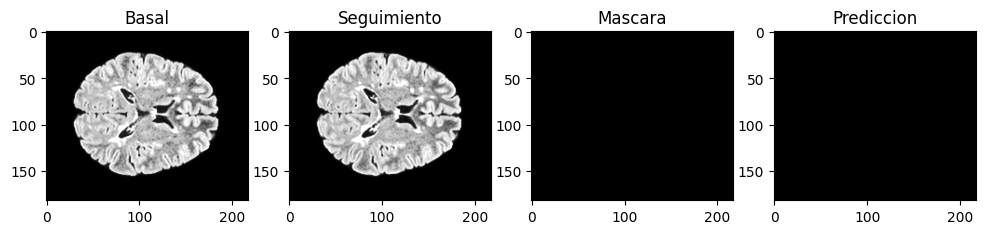

/content/drive/MyDrive/MSSEG/037_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/037_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/037_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/037_mask.nii.gz
tf.Tensor(0.28622413, shape=(), dtype=float32)


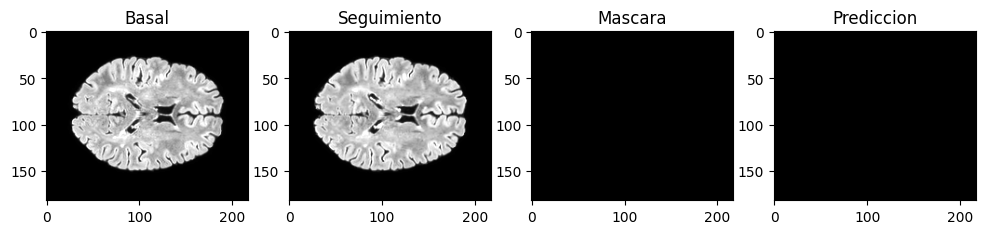

/content/drive/MyDrive/MSSEG/039_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/039_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/039_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/039_mask.nii.gz
tf.Tensor(0.38937384, shape=(), dtype=float32)


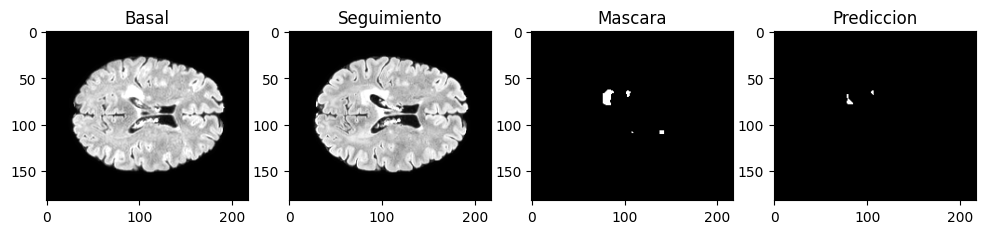

/content/drive/MyDrive/MSSEG/043_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/043_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/043_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/043_mask.nii.gz
tf.Tensor(0.25002405, shape=(), dtype=float32)


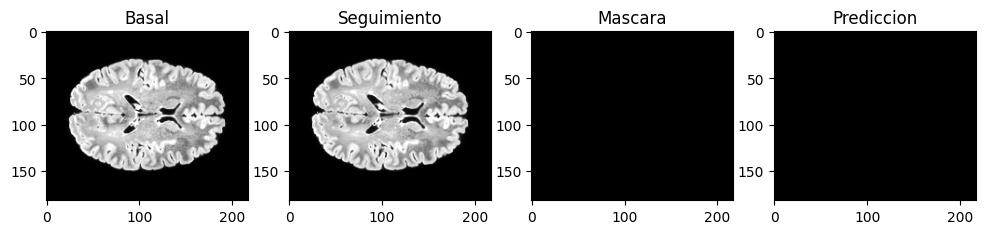

/content/drive/MyDrive/MSSEG/047_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/047_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/047_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/047_mask.nii.gz
tf.Tensor(0.0003447087, shape=(), dtype=float32)


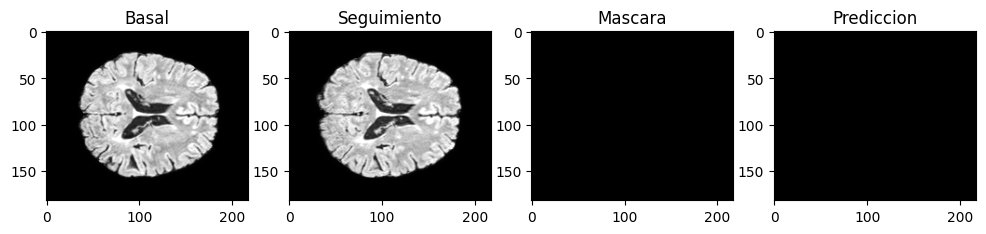

/content/drive/MyDrive/MSSEG/048_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/048_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/048_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/048_mask.nii.gz
tf.Tensor(0.6923208, shape=(), dtype=float32)


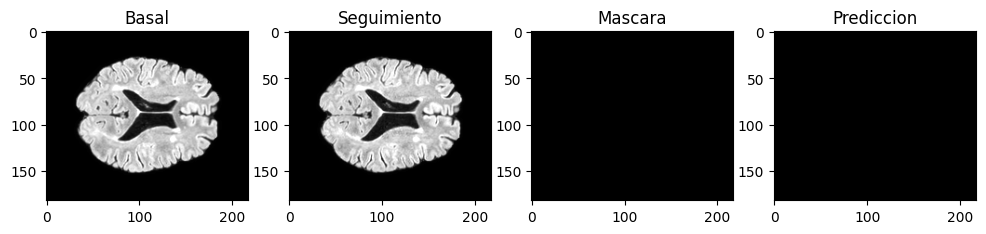

/content/drive/MyDrive/MSSEG/049_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/049_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/049_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/049_mask.nii.gz
tf.Tensor(0.00990099, shape=(), dtype=float32)


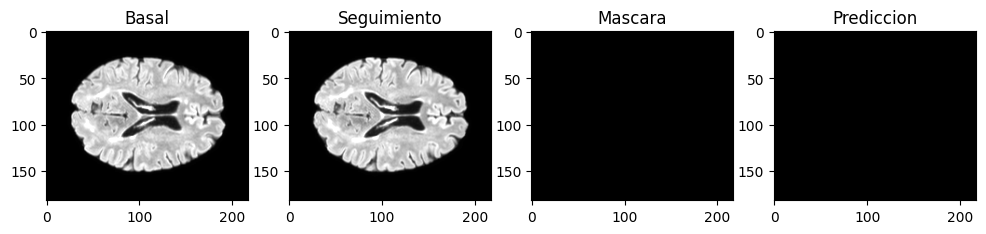

/content/drive/MyDrive/MSSEG/051_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/051_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/051_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/051_mask.nii.gz
tf.Tensor(1.0, shape=(), dtype=float32)


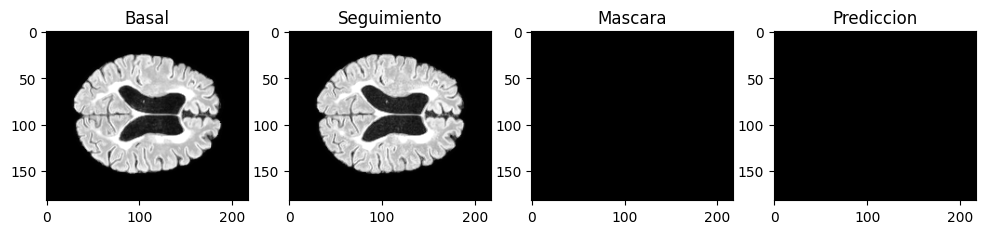

/content/drive/MyDrive/MSSEG/052_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/052_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/052_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/052_mask.nii.gz
tf.Tensor(0.0014265334, shape=(), dtype=float32)


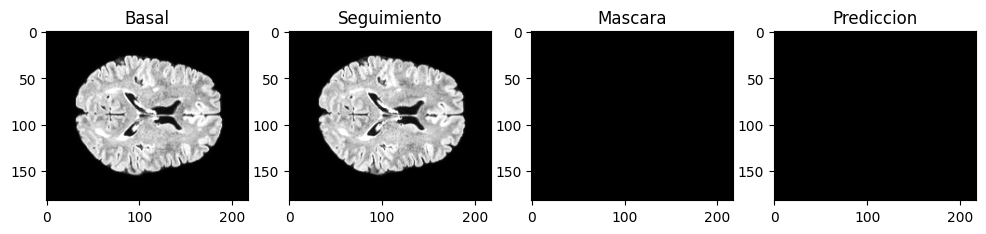

/content/drive/MyDrive/MSSEG/057_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/057_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/057_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/057_mask.nii.gz
tf.Tensor(0.46872947, shape=(), dtype=float32)


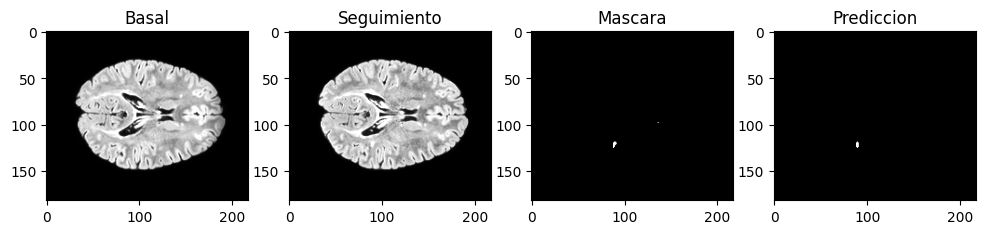

/content/drive/MyDrive/MSSEG/061_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/061_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/061_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/061_mask.nii.gz
tf.Tensor(0.45595524, shape=(), dtype=float32)


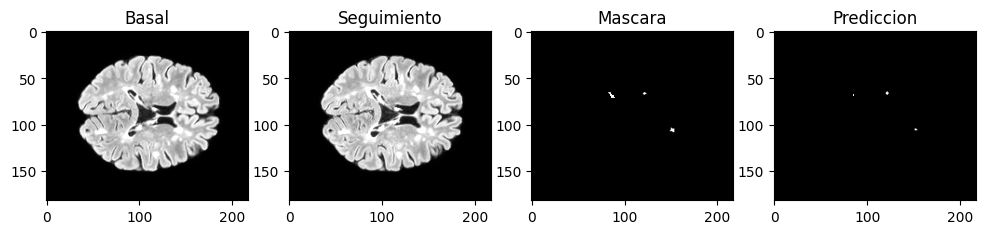

/content/drive/MyDrive/MSSEG/068_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/068_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/068_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/068_mask.nii.gz
tf.Tensor(1.0, shape=(), dtype=float32)


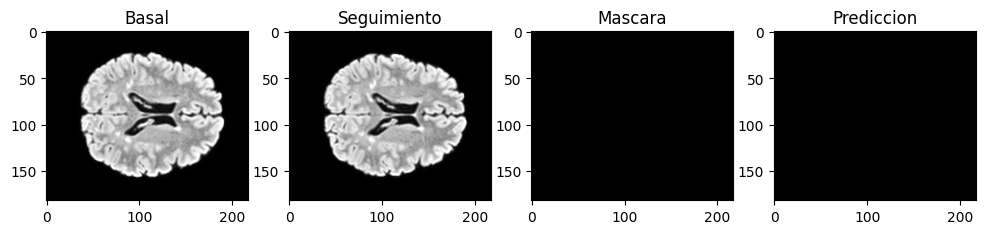

/content/drive/MyDrive/MSSEG/069_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/069_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/069_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/069_mask.nii.gz
tf.Tensor(0.35685793, shape=(), dtype=float32)


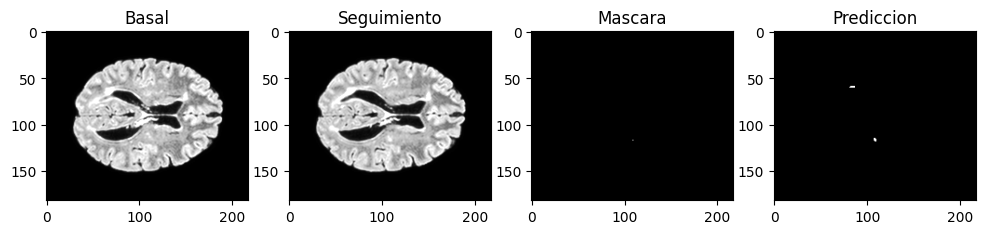

/content/drive/MyDrive/MSSEG/070_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/070_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/070_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/070_mask.nii.gz
tf.Tensor(1.0, shape=(), dtype=float32)


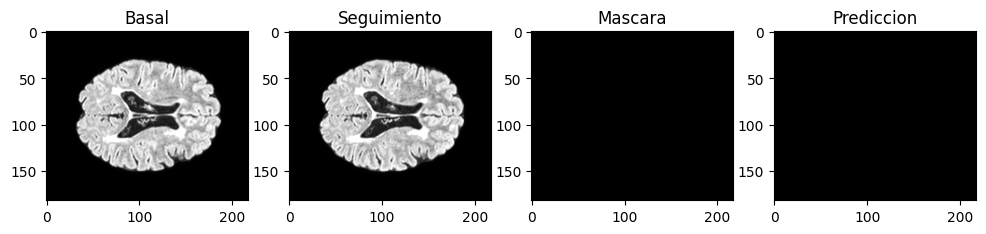

/content/drive/MyDrive/MSSEG/074_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/074_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/074_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/074_mask.nii.gz
tf.Tensor(0.5436731, shape=(), dtype=float32)


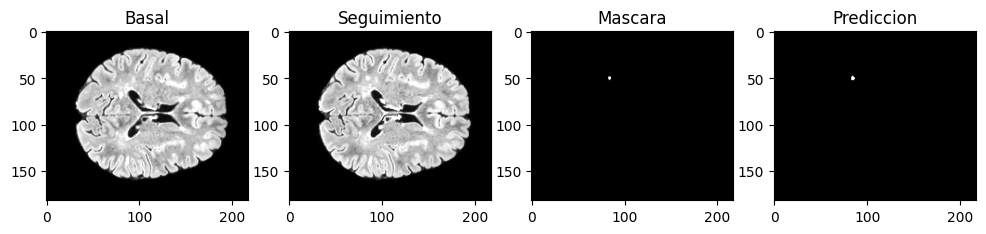

/content/drive/MyDrive/MSSEG/077_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/077_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/077_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/077_mask.nii.gz
tf.Tensor(0.6764944, shape=(), dtype=float32)


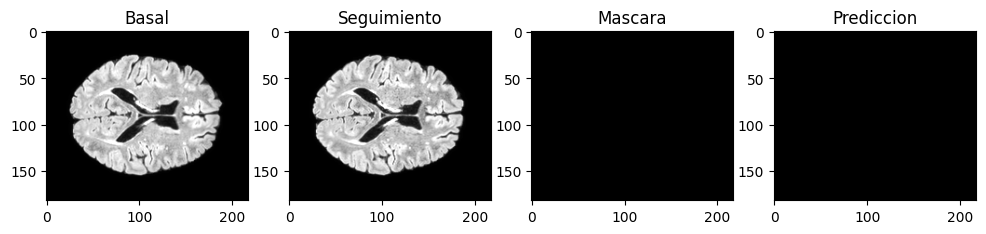

/content/drive/MyDrive/MSSEG/083_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/083_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/083_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/083_mask.nii.gz
tf.Tensor(0.6046695, shape=(), dtype=float32)


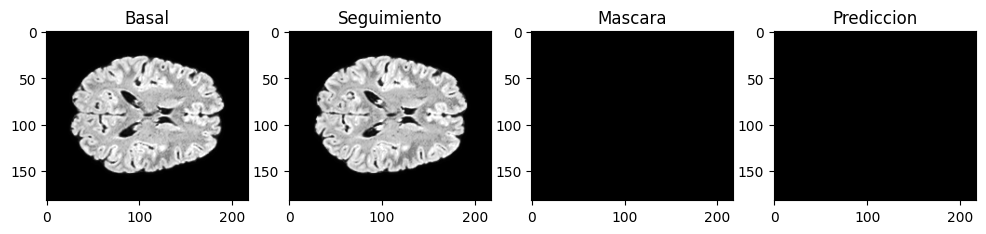

/content/drive/MyDrive/MSSEG/084_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/084_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/084_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/084_mask.nii.gz
tf.Tensor(1.0, shape=(), dtype=float32)


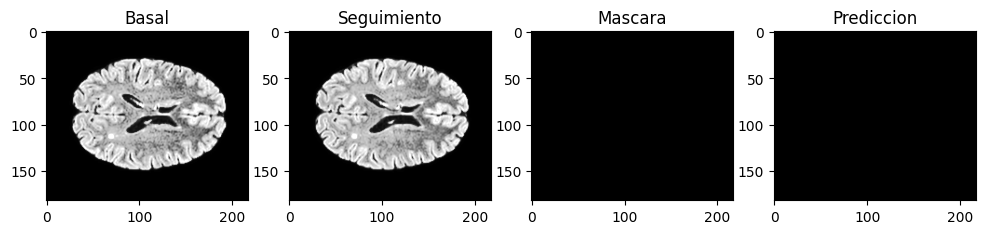

/content/drive/MyDrive/MSSEG/088_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/088_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/088_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/088_mask.nii.gz
tf.Tensor(0.00023250407, shape=(), dtype=float32)


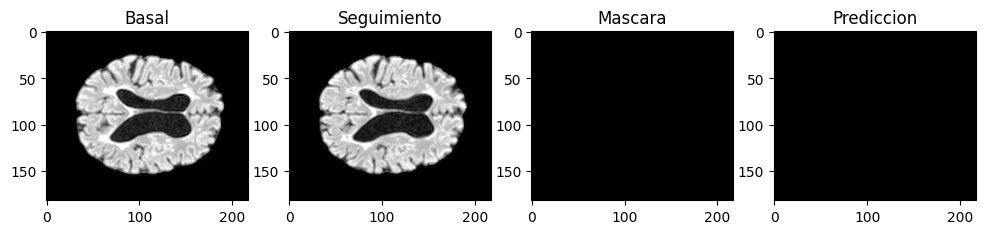

/content/drive/MyDrive/MSSEG/089_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/089_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/089_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/089_mask.nii.gz
tf.Tensor(1.0, shape=(), dtype=float32)


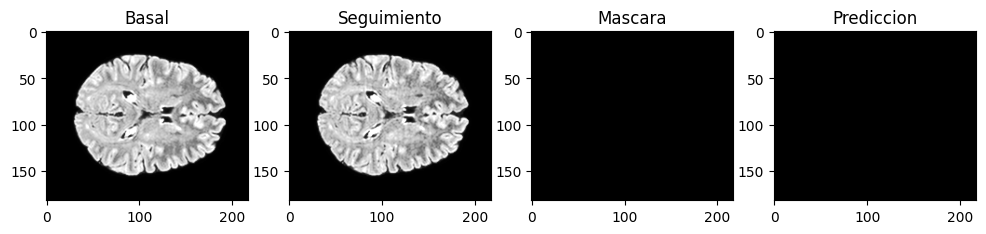

/content/drive/MyDrive/MSSEG/090_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/090_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/090_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/090_mask.nii.gz
tf.Tensor(0.0007686395, shape=(), dtype=float32)


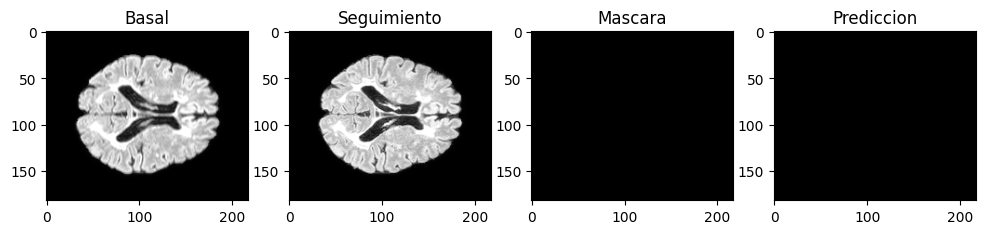

/content/drive/MyDrive/MSSEG/091_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/091_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/091_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/091_mask.nii.gz
tf.Tensor(0.69286805, shape=(), dtype=float32)


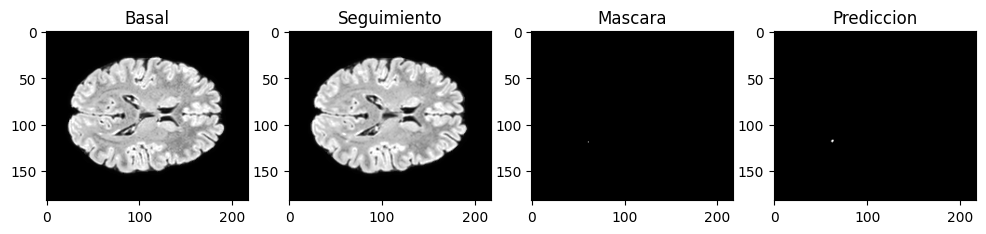

/content/drive/MyDrive/MSSEG/094_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/094_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/094_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/094_mask.nii.gz
tf.Tensor(0.34055784, shape=(), dtype=float32)


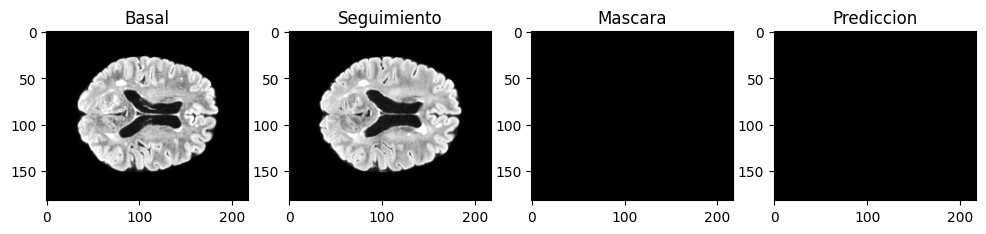

/content/drive/MyDrive/MSSEG/095_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/095_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/095_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/095_mask.nii.gz
tf.Tensor(0.69119084, shape=(), dtype=float32)


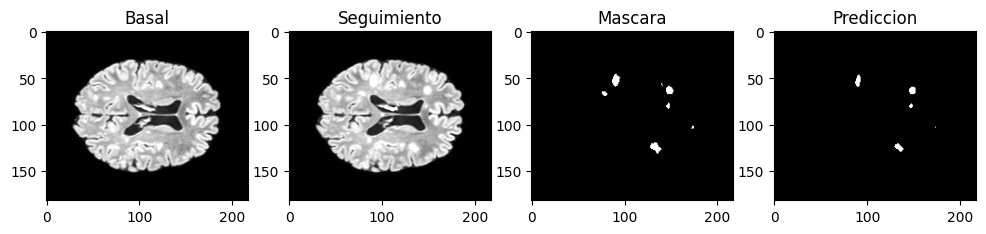

/content/drive/MyDrive/MSSEG/096_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/096_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/096_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/096_mask.nii.gz
tf.Tensor(0.000999001, shape=(), dtype=float32)


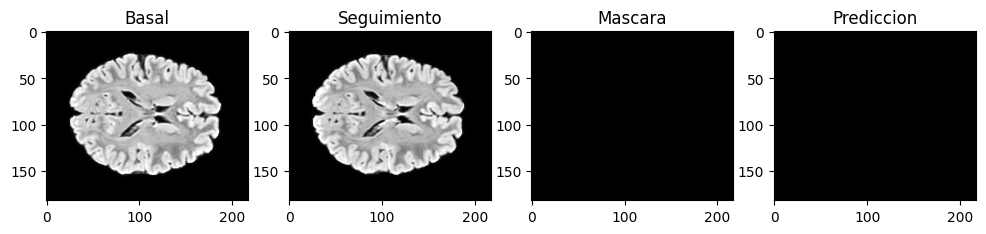

/content/drive/MyDrive/MSSEG/099_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/099_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/099_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/099_mask.nii.gz
tf.Tensor(0.75327873, shape=(), dtype=float32)


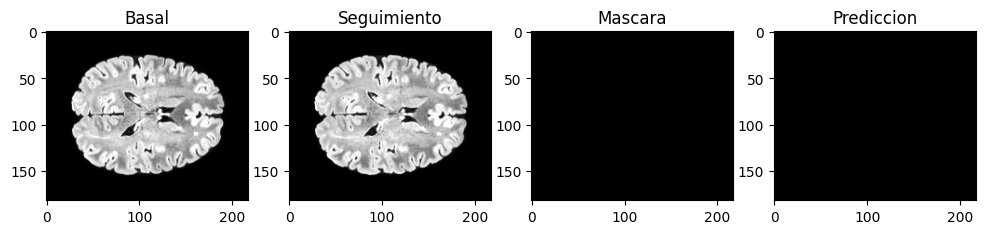

/content/drive/MyDrive/MSSEG/100_time01_FL.nii.gz
/content/drive/MyDrive/MSSEG/100_time02_FL.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/labelsTs_MSSEG/100_mask.nii.gz
/content/drive/MyDrive/Colab Notebooks/nnUNet/nnunetv2/nnUNet_raw_data_base/nnUNet_raw_data/Dataset101_SLEM/Predicciones_transformadas/100_mask.nii.gz
tf.Tensor(0.4000105, shape=(), dtype=float32)


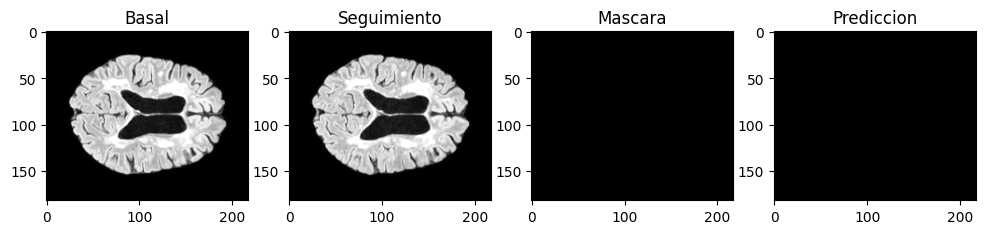

In [ ]:
# Mostramos las imágenes
def muestra_imagenes(i):
  imagen_bas = nib.load(img_basales_MSSEG[i]).get_fdata()
  imagen_seg = nib.load(img_seguimiento_MSSEG[i]).get_fdata()
  mascara = nib.load(y_true[i]).get_fdata()
  prediccion =nib.load(y_pred[i]).get_fdata()
  fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize = (12, 6))
  ax1.imshow(imagen_bas[:, :, imagen_bas.shape[2]//2],cmap='gray')
  ax1.set_title('Basal')
  ax2.imshow(imagen_seg[:, :, imagen_seg.shape[2]//2],cmap='gray')
  ax2.set_title('Seguimiento')
  ax3.imshow(mascara[:, :, mascara.shape[2]//2],cmap='gray')
  ax3.set_title('Mascara')
  ax4.imshow(prediccion[:, :, prediccion.shape[2]//2],cmap='gray')
  ax4.set_title('Prediccion')
  print(img_basales_MSSEG[i])
  print(img_seguimiento_MSSEG[i])
  print(y_true[i])
  print(y_pred[i])
  print(valoresDICE[i])
  plt.show()
  plt.close()
for i in range(40):
  muestra_imagenes(i)